In [1]:
import context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evalpack.metrics import mti, etapr, vus, affiliation
from evalpack.meta_metrics import rbo
from sklearn import metrics
import colorcet as cc
from evalpack.utils.nab_utils import Sweeper

In [2]:
def compute_plot_thresholds(metric, metric_name, labels, scores, scores_names, n_thresholds=100, pos_label=1, max_fpr=0.1):
    metric_outputs = np.zeros((scores.shape[1], n_thresholds))
    thresholds = np.zeros((scores.shape[1], n_thresholds))
    threshold_maxfpr = np.zeros(scores.shape[1], dtype=int)
    for i_score in range(scores.shape[1]):
        score = scores[:, i_score]
        thresholds[i_score] = np.linspace(np.quantile(score, 0.01), np.quantile(score, 0.99), n_thresholds)
        threshold_maxfpr[i_score] = get_thresholds_fpr_pos(labels, score, thresholds[i_score], max_fpr)
        for j_thresh, thresh in enumerate(thresholds[i_score]):
            ij_pred = np.zeros(score.size)
            ij_pred[score > thresh] = 1
            try: 
                metric_outputs[i_score, j_thresh] = metric(labels, ij_pred, pos_label=1)
            except ValueError:
                metric_outputs[i_score, j_thresh] = 0

    colors = sns.color_palette(cc.glasbey, scores.shape[1])
    fig = plt.figure(figsize=(20, 4))
    ax = plt.subplot(111)
    plt.title(metric_name)
    for i_score in range(scores.shape[1]):
        ax.plot(metric_outputs[i_score, :], label=scores_names[i_score], alpha=0.5, color=colors[i_score])
        ax.axvline(np.arange(0, 100, step=1)[threshold_maxfpr[i_score]], alpha=0.5, color=colors[i_score])
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.show()



def get_thresholds_fpr_pos(labels, score, thresholds, max_fpr=0.1):
    for i_thresh, thresh in enumerate(thresholds):
        pred = np.zeros(score.size)
        pred[score > thresh] = 1
        tn, fp, fn, tp = metrics.confusion_matrix(labels, pred).ravel()
        if tn:
            fpr = fp / (fp+tn)
            if fpr <= max_fpr:
                return i_thresh
    return len(thresholds)-1

def get_thresholds_fpr(labels, score, thresholds, max_fpr=0.1):
    thresholds_fpr = list()
    for thresh in thresholds:
        pred = np.zeros(score.size)
        pred[score > thresh] = 1
        tn, fp, fn, tp = metrics.confusion_matrix(labels, pred).ravel()
        if tn:
            fpr = fp / (fp+tn)
            if fpr <= max_fpr:
                thresholds_fpr.append(thresh)
    return np.array(thresholds_fpr)

def compute_all_metrics(metrics: list, metrics_names, tresholded_metrics: list, labels, scores, scores_names, n_thresholds=100, pos_label=1, max_fpr=0.1):
    metrics_outputs = np.zeros((scores.shape[1], len(metrics)))
    thresholds = dict()
    for i_score in range(scores.shape[1]):
        score = scores[:, i_score]
        thresholds_raw = np.linspace(np.quantile(score, 0.01), np.quantile(score, 0.99), n_thresholds)
        thresholds[i_score] = get_thresholds_fpr(labels, score, thresholds_raw, max_fpr)
        for j_metric, metric in enumerate(metrics):
            if tresholded_metrics[j_metric]:
                thresh_values = np.zeros(n_thresholds)
                for j_thresh, thresh in enumerate(thresholds[i_score]):
                    ij_pred = np.zeros(score.size)
                    ij_pred[score > thresh] = 1
                    try:
                        thresh_values[j_thresh] = metric(labels, ij_pred, pos_label=1)
                    except ValueError:
                        thresh_values[j_thresh] = 0
                metrics_outputs[i_score, j_metric] = thresh_values[np.argmax(np.abs(thresh_values))]
            else:
                metrics_outputs[i_score, j_metric] = metric(labels, score, max_fpr=max_fpr)

    df_metrics = pd.DataFrame(metrics_outputs, columns=metrics_names, index=scores_names)
    return df_metrics


def compute_all_metrics_rbo(ground_truth_ranking: list, rbo_params: list, metrics: list, metrics_names, tresholded_metrics: list, 
                            labels, scores, scores_names, n_thresholds=100, pos_label=1, max_fpr=0.1):
    df_metrics = compute_all_metrics(metrics, metrics_names, tresholded_metrics, labels, scores, scores_names, n_thresholds, pos_label, max_fpr)
    rbo_values = np.zeros((len(rbo_params), len(metrics_names)))
    for i_metric in range(len(metrics_names)):
        df_metrics = df_metrics.sort_values(by=metrics_names[i_metric], ascending=False)
        i_ranking = df_metrics.index.to_numpy()
        print(metrics_names[i_metric], i_ranking)
        rbo_f = rbo.RankingSimilarity(ground_truth_ranking, i_ranking)
        for j_param, param in enumerate(rbo_params):
            rbo_values[j_param, i_metric] = rbo_f.rbo(p=param)

    df_rbo = pd.DataFrame(rbo_values, columns=metrics_names, index=rbo_params)
    return df_rbo

In [3]:
def mti_compute(labels, pred, pos_label):
    metric = mti.MTI(false_alarm_weight=0.5)
    return metric.compute_metrics(labels, pred, pos_label)

def mti_recall_compute(labels, pred, pos_label):
    metric = mti.MTI()
    metric.compute_metrics(labels, pred, pos_label)
    return metric.recall_score

def mti_falsealarm_compute(labels, pred, pos_label):
    metric = mti.MTI()
    metric.compute_metrics(labels, pred, pos_label)
    return metric.false_alarm_score

def mti_alarm_compute(labels, pred, pos_label):
    metric = mti.MTI()
    metric.compute_metrics(labels, pred, pos_label)
    return metric.alarm_score

def mti_anticipation_compute(labels, pred, pos_label):
    metric = mti.MTI()
    metric.compute_metrics(labels, pred, pos_label)
    return metric.anticipation_score

def etapr_compute(labels, pred, pos_label):
    return etapr.evaluate_w_streams(labels, pred)['f1']

def mcc_compute(labels, pred, pos_label):
    return metrics.matthews_corrcoef(labels, pred)

def VUS_compute(labels, score, max_fpr):
    return vus.generate_curve(y_true=labels, y_score=score, slidingWindow=50)[6]

def nab_compute(labels, score, threshold):
    timestamps = pd.date_range(start=np.datetime64('2023-11-07 00:00:00'), freq='1S', periods=len(score))

    change_points = np.where(np.diff(labels) != 0)[0]
    windows = [(timestamps[change_points[i]], timestamps[change_points[i+1]]) for i in range(len(change_points) //2)]

    nab = Sweeper(costMatrix={
    	"tpWeight": 1.0,
    	"fnWeight": 1.0,
    	"fpWeight": 0.11,
    	"tnWeight": 1.0
	})
    a = nab.scoreDataSet(timestamps=timestamps, anomalyScores=score,
                    windowLimits=windows, dataSetName='',
                     threshold=threshold)
    return a[1]

In [4]:
def get_nab_dataset(labels, score, n_thresholds=100, max_fpr=0.1):
    thresholds_raw= np.linspace(np.quantile(score, 0.01), np.quantile(score, 0.99), n_thresholds)
    thresholds = get_thresholds_fpr(labels, score, thresholds_raw, max_fpr)
    nab_values = np.zeros(len(thresholds))
    for i_thresh, thresh in enumerate(thresholds):
        tmp_nab = nab_compute(labels, score, thresh)
        if tmp_nab is None:
            nab_values[i_thresh] = -np.inf
        else:
            nab_values[i_thresh] = tmp_nab[1]
    return nab_values.max()

In [5]:
import pandas as pd
import context
import numpy as np

df0 = pd.read_csv('../datasets/synthetic_simple_cases.csv')
dfA = df0[['labels', 'A']]

labels = np.zeros(len(df0))
labels[df0.labels.values == -1] = 1
timestamps = pd.date_range(start=np.datetime64('2023-11-07 00:00:00'), freq='1S', periods=len(df0))
nab = Sweeper(costMatrix={
    	"tpWeight": 1.0,
    	"fnWeight": 1.0,
    	"fpWeight": 0.11,
    	"tnWeight": 1.0
	})
a = nab.scoreDataSet(timestamps=timestamps, anomalyScores=df0['A'].values,
                    windowLimits=[(timestamps[3001], timestamps[7500])], dataSetName='Simple',
                     threshold=0.1)

# b = nab.calcSweepScore(timestamps=timestamps, anomalyScores=df0['B'].values,
#                      windowLimits=[(timestamps[3001], timestamps[7500])], dataSetName='Simple')

# c = nab.calcScoreByThreshold(b)

# a[1]
# nab_compute(df0.labels, df0.A.values, 1)[1]
print('A', get_nab_dataset(labels=labels, score=df0.A.values))
print('B', get_nab_dataset(labels=labels, score=df0.B.values))
print('C', get_nab_dataset(labels=labels, score=df0.C.values))
print('D', get_nab_dataset(labels=labels, score=df0.D.values))
print('E', get_nab_dataset(labels=labels, score=df0.E.values))

rbo_metric = rbo.RankingSimilarity(['A', 'B', 'C', 'D', 'E'], ['B', 'C', 'A', 'D', 'E'])
print(0.2, rbo_metric.rbo(p=0.2))
print(1, rbo_metric.rbo(p=1))

A -2.08004498562008
B 0.9991830690075074
C 0.9899629658734678
D -6.3860552383895905
E -inf
0.2 0.11968000000000002
1 0.7


In [9]:
df0 = pd.read_csv('../datasets/synthetic_simple_cases.csv')

labels = df0.labels.values
labels[labels == 1] = 0
labels[labels == -1] = 1

scores = df0.values[:, 1:]
scores_names = df0.columns.to_numpy()[1:]

metrics_to_compute = [mti_compute, metrics.f1_score, metrics.roc_auc_score,
                    #    affiliation.affiliation_f1_score, 
                      etapr_compute, mcc_compute, VUS_compute
                      ]
metrics_name = ['mti', 'F1', 'AUC',
                #  'Affiliation',
                 'eTaPR', 'MCC', 'VUS'
                 ]
metrics_thresholded = [True, True, False, 
                    #    True, 
                       True, True, False
                       ]

ground_truth = ['A', 'B', 'C', 'D', 'E']
rbo_params = [0.2, 0.5, 1]
# print(compute_all_metrics(metrics_to_compute, metrics_name, metrics_thresholded, labels, scores, scores_names))
print(compute_all_metrics_rbo(ground_truth, rbo_params, metrics_to_compute, metrics_name, metrics_thresholded, labels, scores, scores_names))

compute_plot_thresholds(mti_compute, 'mti', labels, scores, scores_names)
# compute_plot_thresholds(mti_recall_compute, 'mti Recall', labels, scores, scores_names)
# compute_plot_thresholds(mti_falsealarm_compute, 'mti False Alarm', labels, scores, scores_names)
# compute_plot_thresholds(mti_alarm_compute, 'mti Alarm', labels, scores, scores_names)
# compute_plot_thresholds(mti_anticipation_compute, 'mti Anticipation', labels, scores, scores_names)
# compute_plot_thresholds(metrics.f1_score, 'F1', labels, scores, scores_names)
# compute_plot_thresholds(metrics_toolbox.affiliation_f1_score, 'Affiliation', labels, scores, scores_names)
# compute_plot_thresholds(etapr_compute, 'eTaPR', labels, scores, scores_names)
# compute_plot_thresholds(mcc_compute, 'MCC', labels, scores, scores_names)

mti ['A' 'B' 'C' 'D' 'E']
F1 ['B' 'A' 'C' 'D' 'E']
AUC ['B' 'A' 'C' 'D' 'E']
eTaPR ['B' 'A' 'C' 'D' 'E']
MCC ['B' 'A' 'C' 'D' 'E']
VUS ['A' 'B' 'C' 'D' 'E']
         mti       F1      AUC    eTaPR      MCC      VUS
0.2  0.99968  0.19968  0.19968  0.19968  0.19968  0.99968
0.5  0.96875  0.46875  0.46875  0.46875  0.46875  0.96875
1.0  1.00000  0.80000  0.80000  0.80000  0.80000  1.00000


In [ ]:
df1 = pd.read_csv('../datasets/synthetic_two_asymetric_areas.csv', index_col=0)
df1 = df1[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'first_half_score', 'shift_100_perfect_score', 'perfect_score_with_FA',
                 'second_half_score', 'random_score']]
labels = df1.labels.values
labels[labels == 1] = 0
labels[labels == -1] = 1

scores = df1.values[:, 1:]
scores_names = df1.columns.to_numpy()[1:]

metrics_to_compute = [mti_compute, metrics.f1_score, metrics.roc_auc_score, metrics_toolbox.affiliation_f1_score, 
                      etapr_compute, mcc_compute, VUS_compute
                      ]
metrics_name = ['mti', 'F1', 'AUC', 'Affiliation',
                 'eTaPR', 'MCC', 'VUS'
                 ]
metrics_thresholded = [True, True, False, True, 
                       True, True, False
                       ]

# ground_truth = ['perfect_score_with_anticipation', 'perfect_score', 'shift_100_perfect_score', 'first_half_score', 'perfect_score_with_FA',
#                 'first_area_score', 'second_area_score', 'second_half_score', '1/5_first_area_score', 'reverse_score', 'random_score']
ground_truth = ['perfect_score_with_anticipation', 'perfect_score', 'first_half_score', 'perfect_score_with_FA', 'shift_100_perfect_score',
                 'second_half_score', 'random_score']
rbo_params = [0.2, 0.5, 1]
# print(compute_all_metrics(metrics_to_compute, metrics_name, metrics_thresholded, labels, scores, scores_names))
print(compute_all_metrics_rbo(ground_truth, rbo_params, metrics_to_compute, metrics_name, metrics_thresholded, labels, scores, scores_names))

# compute_plot_thresholds(mti_compute, 'mti', labels, scores, scores_names)
# compute_plot_thresholds(mti_recall_compute, 'mti Recall', labels, scores, scores_names)
# compute_plot_thresholds(mti_falsealarm_compute, 'mti False Alarm', labels, scores, scores_names)
# compute_plot_thresholds(mti_alarm_compute, 'mti Alarm', labels, scores, scores_names)
# compute_plot_thresholds(mti_anticipation_compute, 'mti Anticipation', labels, scores, scores_names)
# compute_plot_thresholds(metrics.f1_score, 'F1', labels, scores, scores_names)
# compute_plot_thresholds(metrics_toolbox.affiliation_f1_score, 'Affiliation', labels, scores, scores_names)
# compute_plot_thresholds(etapr_compute, 'eTaPR', labels, scores, scores_names)
# compute_plot_thresholds(mcc_compute, 'MCC', labels, scores, scores_names)

NameError: name 'metrics_toolbox' is not defined

In [ ]:
df1 = pd.read_csv('../datasets/synthetic_two_asymetric_areas.csv', index_col=0)
df1 = df1[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'first_half_score', 'shift_100_perfect_score', 'perfect_score_with_FA',
                 'second_half_score', 'random_score']]
labels = df1.labels.values
labels[labels == 1] = 0
labels[labels == -1] = 1

# print('perfect_score_with_anticipation', get_nab_dataset(labels=labels, score=df1.perfect_score_with_anticipation.values))
# print('perfect_score', get_nab_dataset(labels=labels, score=df1.perfect_score.values))
# print('first_half_score', get_nab_dataset(labels=labels, score=df1.first_half_score.values))
# print('shift_100_perfect_score', get_nab_dataset(labels=labels, score=df1.shift_100_perfect_score.values))
# print('perfect_score_with_FA', get_nab_dataset(labels=labels, score=df1.perfect_score_with_FA.values))
# print('second_half_score', get_nab_dataset(labels=labels, score=df1.second_half_score.values))
# print('random_score', get_nab_dataset(labels=labels, score=df1.random_score.values))

rbo_metric = rbo.RankingSimilarity(['perfect_score_with_anticipation', 'perfect_score', 'first_half_score', 'shift_100_perfect_score',
                                     'perfect_score_with_FA',
                 'second_half_score', 'random_score'], 
                 ['random_score', 'first_half_score', 'second_half_score', 'perfect_score', 'perfect_score_with_FA', 
                  'shift_100_perfect_score', 'perfect_score_with_anticipation'])
print(0.2, rbo_metric.rbo(p=0.2))
print(1, rbo_metric.rbo(p=1))

0.2 0.014899200000000001
1 0.4666666666666667


In [ ]:
df2 = pd.read_csv('../datasets/synthetic_two_asymetric_areas_and_some_single_points.csv', index_col=0)
df2 = df2[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'areas_perfect', 
             'singles_perfect', 'random_score']]

labels2 = df2.labels.values
labels2[labels2 == 1] = 0
labels2[labels2 == -1] = 1

def mti_compute(labels, pred, pos_label):
    metric = mti.mti(anticipation_weight=2, recall_weight=1, alarm_weight=1, false_alarm_weight=1, anticipation_period=10)
    return metric.compute_metrics(labels, pred, pos_label)

scores2 = df2.values[:, 1:]
scores_names2 = df2.columns.to_numpy()[1:]

metrics_to_compute = [mti_compute, 
                    #   metrics.f1_score, metrics.roc_auc_score, metrics_toolbox.affiliation_f1_score, 
                    #   etapr_compute, mcc_compute, VUS_compute
                      ]
metrics_name = ['mti', 
                # 'F1', 'AUC', 'Affiliation',
                #  'eTaPR', 'MCC', 'VUS'
                 ]
metrics_thresholded = [True, 
                    #    True, False, True, 
                    #    True, True, False
                       ]

ground_truth2 = ['perfect_score_with_anticipation', 'perfect_score', 'areas_perfect', 'perfect_score_with_FA', 
                'first_area_pefect', 'second_area_perfect', 'singles_perfect', 'win100_score', 'reverse_score', 'random_score']
# ground_truth2 = ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'areas_perfect', 
#              'singles_perfect', 'random_score']
rbo_params = [0.2, 0.5, 1]

# # print(compute_all_metrics(metrics_to_compute, metrics_name, metrics_thresholded, labels2, scores2, scores_names2))

print(compute_all_metrics_rbo(ground_truth2, rbo_params, metrics_to_compute, metrics_name, metrics_thresholded, labels2, scores2, scores_names2))

# compute_plot_thresholds(mti_compute, 'mti', labels2, scores2, scores_names2)
# compute_plot_thresholds(mti_recall_compute, 'mti Recall', labels2, scores2, scores_names2)
# compute_plot_thresholds(mti_falsealarm_compute, 'mti False Alarm', labels2, scores2, scores_names2)
# compute_plot_thresholds(mti_alarm_compute, 'mti Alarm', labels2, scores2, scores_names2)
# compute_plot_thresholds(mti_anticipation_compute, 'mti Anticipation', labels2, scores2, scores_names2)
# compute_plot_thresholds(metrics.f1_score, 'F1', labels2, scores2, scores_names2)
# compute_plot_thresholds(metrics_toolbox.affiliation_f1_score, 'Affiliation', labels2, scores2, scores_names2)
# compute_plot_thresholds(etapr_compute, 'eTaPR', labels2, scores2, scores_names2)
# compute_plot_thresholds(mcc_compute, 'MCC', labels2, scores2, scores_names2)

wFAAR ['perfect_score_with_anticipation' 'perfect_score' 'singles_perfect'
 'perfect_score_with_FA' 'areas_perfect' 'random_score']
        wFAAR
0.2  0.987328
0.5  0.915625
1.0  0.813889


In [ ]:
df2 = pd.read_csv('../datasets/synthetic_two_asymetric_areas_and_some_single_points.csv', index_col=0)
df2 = df2[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'areas_perfect', 
             'singles_perfect', 'random_score']]

labels2 = df2.labels.values
labels2[labels2 == 1] = 0
labels2[labels2 == -1] = 1


# print('perfect_score_with_anticipation', get_nab_dataset(labels=labels2, score=df2.perfect_score_with_anticipation.values))
# print('perfect_score', get_nab_dataset(labels=labels2, score=df2.perfect_score.values))
# print('perfect_score_with_FA', get_nab_dataset(labels=labels2, score=df2.perfect_score_with_FA.values))
# print('areas_perfect', get_nab_dataset(labels=labels2, score=df2.areas_perfect.values))
# print('singles_perfect', get_nab_dataset(labels=labels2, score=df2.singles_perfect.values))
# print('random_score', get_nab_dataset(labels=labels2, score=df2.random_score.values))

rbo_metric = rbo.RankingSimilarity(['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'areas_perfect', 
             'singles_perfect', 'random_score'], 
                 ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'singles_perfect', 'random_score',
                   'areas_perfect',
                  ])
print(0.2, rbo_metric.rbo(p=0.2))
print(1, rbo_metric.rbo(p=1))

0.2 0.9980800000000002
1 0.9249999999999999


In [ ]:
df3 = pd.read_csv('../datasets/synthetic_many_small_areas.csv', index_col=0)
df3 = df3[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas', 'shift_100', 
           'perfect_score_with_FA', 'perfect_score_second_half_each_areas', 'perfect_score_half_areas', 'random_score']]

labels3 = df3.labels.values
labels3[labels3 == 1] = 0
labels3[labels3 == -1] = 1

scores3 = df3.values[:, 1:]
scores_names3 = df3.columns.to_numpy()[1:]


def mti_compute(labels, pred, pos_label):
    metric = mti.mti(anticipation_weight=1, recall_weight=1, alarm_weight=1, false_alarm_weight=1, anticipation_period='default')
    return metric.compute_metrics(labels, pred, pos_label)

metrics_to_compute = [mti_compute, 
                      metrics.f1_score, metrics.roc_auc_score, metrics_toolbox.affiliation_f1_score, 
                      etapr_compute, mcc_compute, VUS_compute
                      ]
metrics_name = ['mti', 
                'F1', 'AUC', 'Affiliation',
                 'eTaPR', 'MCC', 'VUS'
                 ]
metrics_thresholded = [True, 
                       True, False, True, 
                       True, True, False
                       ]



# ground_truth3 = ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas', 'shift_100', 'perfect_score_with_FA',
#                  'perfect_score_second_half_each_areas', 'perfect_score_half_areas ' ,'reverse_score', 'always_high', 'random_score']
ground_truth3 = ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas', 'shift_100', 
                 'perfect_score_with_FA', 'perfect_score_second_half_each_areas', 'perfect_score_half_areas ', 'random_score']
rbo_params = [0.2, 0.5, 1]

# print(compute_all_metrics(metrics_to_compute, metrics_name, metrics_thresholded, labels3, scores3, scores_names3))

print(compute_all_metrics_rbo(ground_truth3, rbo_params, metrics_to_compute, metrics_name, metrics_thresholded, labels3, scores3, scores_names3))

# compute_plot_thresholds(mti_compute, 'mti', labels3, scores3, scores_names3)
# compute_plot_thresholds(mti_recall_compute, 'mti Recall', labels3, scores3, scores_names3)
# compute_plot_thresholds(mti_falsealarm_compute, 'mti False Alarm', labels3, scores3, scores_names3)
# compute_plot_thresholds(mti_alarm_compute, 'mti Alarm', labels3, scores3, scores_names3)
# compute_plot_thresholds(mti_anticipation_compute, 'mti Anticipation', labels3, scores3, scores_names3)
# compute_plot_thresholds(metrics.f1_score, 'F1', labels3, scores3, scores_names3)
# compute_plot_thresholds(metrics_toolbox.affiliation_f1_score, 'Affiliation', labels3, scores3, scores_names3)
# compute_plot_thresholds(etapr_compute, 'eTaPR', labels3, scores3, scores_names3)
# compute_plot_thresholds(mcc_compute, 'MCC', labels3, scores3, scores_names3)

wFAAR ['perfect_score_with_anticipation' 'perfect_score'
 'perfect_score_first_half_each_areas' 'perfect_score_with_FA'
 'perfect_score_second_half_each_areas' 'perfect_score_half_areas'
 'random_score' 'shift_100']
F1 ['perfect_score' 'perfect_score_with_FA' 'perfect_score_with_anticipation'
 'perfect_score_first_half_each_areas'
 'perfect_score_second_half_each_areas' 'perfect_score_half_areas'
 'shift_100' 'random_score']
AUC ['perfect_score' 'perfect_score_with_FA' 'perfect_score_with_anticipation'
 'perfect_score_second_half_each_areas' 'perfect_score_half_areas'
 'perfect_score_first_half_each_areas' 'shift_100' 'random_score']
Affiliation ['perfect_score' 'perfect_score_with_FA' 'perfect_score_with_anticipation'
 'perfect_score_second_half_each_areas'
 'perfect_score_first_half_each_areas' 'shift_100' 'random_score'
 'perfect_score_half_areas']
eTaPR ['perfect_score' 'perfect_score_with_anticipation' 'perfect_score_with_FA'
 'perfect_score_second_half_each_areas'
 'perfect_score

In [ ]:
df3 = pd.read_csv('../datasets/synthetic_many_small_areas.csv', index_col=0)
df3 = df3[['labels', 'perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas',
           'shift_100',  'perfect_score_with_FA',  'perfect_score_second_half_each_areas', 'perfect_score_half_areas', 'random_score']]

labels3 = df3.labels.values
labels3[labels3 == 1] = 0
labels3[labels3 == -1] = 1

# print('perfect_score_with_anticipation', get_nab_dataset(labels=labels3, score=df3.perfect_score_with_anticipation.values))
# print('perfect_score', get_nab_dataset(labels=labels3, score=df3.perfect_score.values))
# print('perfect_score_first_half_each_areas', get_nab_dataset(labels=labels3, score=df3.perfect_score_first_half_each_areas.values))
# print('perfect_score_with_FA', get_nab_dataset(labels=labels3, score=df3.perfect_score_with_FA.values))
# print('shift_100', get_nab_dataset(labels=labels3, score=df3.shift_100.values))
# print('perfect_score_second_half_each_areas', get_nab_dataset(labels=labels3, score=df3.perfect_score_second_half_each_areas.values))
# print('perfect_score_half_areas', get_nab_dataset(labels=labels3, score=df3.perfect_score_half_areas.values))
# print('random_score', get_nab_dataset(labels=labels3, score=df3.random_score.values))

rbo_metric = rbo.RankingSimilarity(['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas',
           'shift_100',  'perfect_score_with_FA',  'perfect_score_second_half_each_areas', 'perfect_score_half_areas', 'random_score'], 
                 ['random_score', 'perfect_score_half_areas', 'perfect_score_second_half_each_areas', 'perfect_score_first_half_each_areas',
                  'perfect_score', 'perfect_score_with_FA', 'perfect_score_with_anticipation', 'shift_100'])
print(0.2, rbo_metric.rbo(p=0.2))
print(1, rbo_metric.rbo(p=1))

0.2 0.0023367923809523815
1 0.39672619047619045


In [ ]:
def get_contiguous_region(vals, labels=[0, 1]):
    changes_index = np.where(vals[:-1] != vals[1:])[0]
    regions = {label: list() for label in labels}
    if len(changes_index):
        for i, ind in enumerate(changes_index):
            if ((i != len(changes_index)-1)):
                regions[vals[ind+1]].append((ind+1, changes_index[i+1]+1))
            else:
                regions[vals[ind+1]].append((ind+1, len(vals)))
        regions[vals[0]].append((0, changes_index[0]+5))
    else:
        regions[vals[0]].append((0, len(vals)))
    return regions

KeyError: 0.0

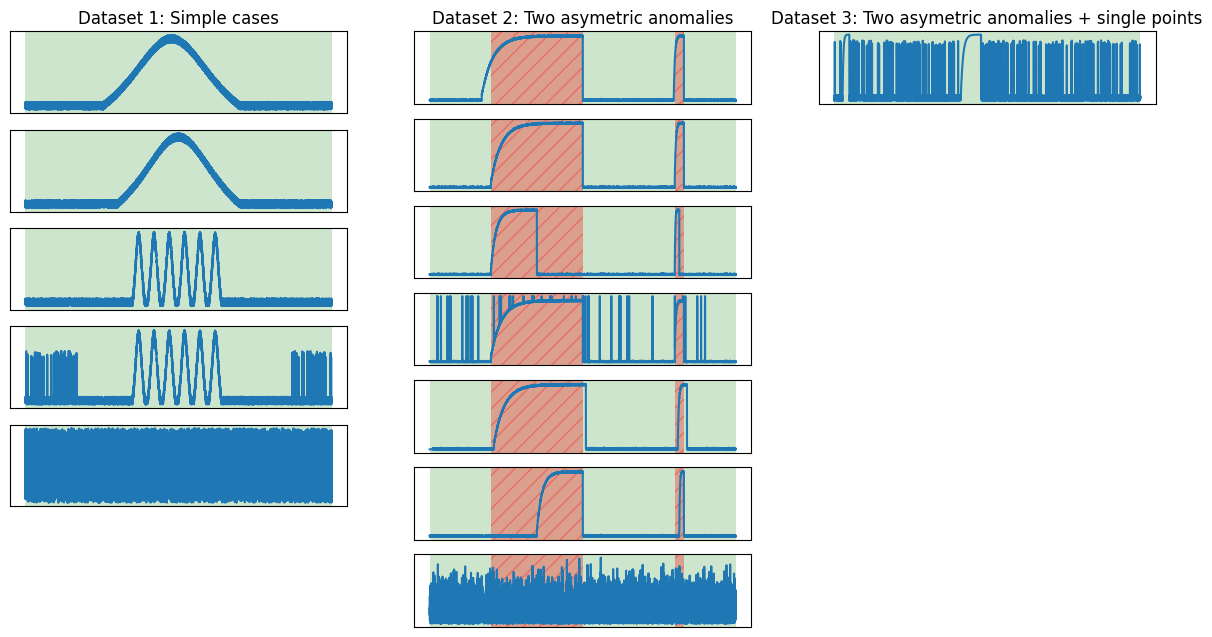

In [ ]:
plt.figure(figsize=(20, 10))
# Simple
col_df0 = ['A', 'B', 'C', 'D', 'E']
for i_col, col in enumerate(col_df0):
    plt.subplot(8, 4, 1 + i_col*4)
    if i_col == 0:
        plt.title('Dataset 1: Simple cases')
    plt.plot(df0[col])
    plt.xticks([])
    plt.yticks([])
    label_tmp = np.zeros(len(df0))
    label_tmp[df0.labels.values == -1] = 1
    plt.axvspan(0, len(df0), color='green', alpha=0.2, lw=0)
    regions_red = get_contiguous_region(label_tmp)[1]
    for i, region in enumerate(regions_red):
        plt.axvspan(region[0], region[1], color='red', alpha=0.3, lw=0, hatch='//')
# Synth 1
col_df1 = ['perfect_score_with_anticipation', 'perfect_score', 'first_half_score', 'perfect_score_with_FA', 'shift_100_perfect_score',
                 'second_half_score', 'random_score']
for i_col, col in enumerate(col_df1):
    plt.subplot(9, 4, 2 + i_col*4)
    if i_col == 0:
        plt.title('Dataset 2: Two asymetric anomalies')
    plt.plot(df1[col])
    plt.xticks([])
    plt.yticks([])
    plt.axvspan(0, len(df1), color='green', alpha=0.2, lw=0)
    regions_red = get_contiguous_region(df1.labels.values)[1]
    for i, region in enumerate(regions_red):
        plt.axvspan(region[0], region[1], color='red', alpha=0.3, lw=0, hatch='//')
# Synth 2
col_df2 = ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_with_FA', 'areas_perfect', 
             'singles_perfect', 'random_score']
for i_col, col in enumerate(col_df2):
    plt.subplot(9, 4, 3 + i_col*4)
    if i_col == 0:
        plt.title('Dataset 3: Two asymetric anomalies + single points')
    plt.plot(df2[col])
    plt.xticks([])
    plt.yticks([])
    plt.axvspan(0, len(df2), color='green', alpha=0.2, lw=0)
    regions_red = get_contiguous_region(df2.labels.values, labels=[-1, 1])[-1]
    for i, region in enumerate(regions_red):
        plt.axvspan(region[0], region[1], color='red', alpha=0.3, lw=0.5, hatch='//')
# Synth 3
col_df3 = ['perfect_score_with_anticipation', 'perfect_score', 'perfect_score_first_half_each_areas', 'perfect_score_with_FA', 
           'shift_100', 'perfect_score_second_half_each_areas', 'perfect_score_half_areas', 'random_score']
for i_col, col in enumerate(col_df3):
    plt.subplot(8, 4, 4 + i_col*4)
    if i_col == 0:
        plt.title('Dataset 4: Many short anomalies')
    plt.plot(df3[col])
    plt.xticks([])
    plt.yticks([])
    plt.axvspan(0, len(df3), color='green', alpha=0.2, lw=0)
    regions_red = get_contiguous_region(df3.labels.values)[1]
    for i, region in enumerate(regions_red):
        plt.axvspan(region[0], region[1], color='red', alpha=0.3, lw=0, hatch='//')
plt.savefig('synth_datasets.png', transparent=True)
plt.show()